In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from IPython.display import clear_output
import time

np.set_printoptions(suppress=True)

In [2]:
train = 200

M = 3
p = 4
T = train - p
k = M*(M*p+1)

print("k: " + str(k))

np.random.seed(12345)

k: 39


In [3]:
def transformation(series, code, transform=True):
    
    if transform:
        if code == 1:
            # none
            transformed_series = series
        elif code == 2:
            # first-difference
            transformed_series = first_difference = series[1:] - series[:-1]
        elif code == 3:
            # second-difference
            transformed_series = series[2:] - series[:-2]
        elif code == 4:
            # log
            transformed_series = np.log(series)
        elif code == 5:
            # first-difference log
            transformed_series = np.log(series[1:]) - np.log(series[:-1])
        elif code == 6:
            # second-difference log
            transformed_series = np.log(series[2:]) - np.log(series[:-2])

        return transformed_series
    else:
        return series

In [4]:
ds = pd.read_csv("data/fred_qd.csv")

In [5]:
transform=True

gdp = transformation(ds["GDPC1"].iloc[2:].to_numpy(), 5, transform)
cpi = transformation(ds["CPIAUCSL"].iloc[2:].to_numpy(), 6, transform)
fedfund = transformation(ds["FEDFUNDS"].iloc[2:].to_numpy(), 2, transform)
compi = transformation(ds["PPIACO"].iloc[2:].to_numpy(), 6, transform)
borrowings = transformation(ds["TOTRESNS"].iloc[2:].to_numpy(), 6, transform)
sp500 = transformation(ds["S&P 500"].iloc[2:].to_numpy(), 5, transform)
m2 = transformation(ds["M2REAL"].iloc[2:].to_numpy(), 5, transform)

series_total = [gdp, cpi, fedfund]
#series_total = [gdp, cpi, fedfund, compi, borrowings , sp500, m2]

In [6]:
def create_data(series, train_indices, T, M, p, k):
    
    # Create data
    lagged_y = np.ones((T,M*p+1))
    lagged_series = []
    y_series = []
    
    for s in series:
        lagged_series.append(s[:train_indices])

    position_counter = 1 #Constant is added in front

    for m in range(M):
        y_m = lagged_series[m]
        for i in range(1,p+1):
            lagged_y[:,position_counter] = y_m[(p-i):-i]
            position_counter += 1

    # Create lagged dependent matrix   
    X = np.zeros((T,M,k))
    stacked_X = np.zeros((M,T,k))

    for m in range(M):
        total_lags = M*p+1
        stacked_X[m,:,m*(total_lags):(m+1)*total_lags] = lagged_y

    stacked_list = list()

    for m in range(M):
        stacked_list.append(stacked_X[m])

    for t in range(T):
        X[t] = np.squeeze(np.dstack(tuple(stacked_list)))[t].T
    
    for s in series:
        y_series.append(s[p:train_indices])
        
    y = np.array(y_series)
    y = y.T
    
    return X, y

In [9]:
# Create matrices from FED-QD
X, y = create_data(series_total, train, T, M, p, k)

In [10]:
def create_dgp_data():

    # Create data
    lagged_y = np.zeros((T,M*p))

    locations = np.random.randint(0,10,size=M)
    position_counter = 0

    for m in range(M):
        y_m = np.random.normal(loc=locations[m], scale=2, size=T+p)
        for i in range(1,p+1):
            lagged_y[:,position_counter] = y_m[(p-i):-i]
            position_counter += 1

    # Create lagged dependent matrix   
    X = np.zeros((T,M,k))
    stacked_X = np.zeros((M,T,k))

    for m in range(M):
        total_lags = M*p
        stacked_X[m,:,m*(total_lags):(m+1)*total_lags] = lagged_y

    stacked_list = list()

    for m in range(M):
        stacked_list.append(stacked_X[m])

    for t in range(T):
        X[t] = np.squeeze(np.dstack(tuple(stacked_list)))[t].T

    # Create betas
    ub = 5
    lb = 0
    difference = 0.5
    scale = 0.010
    sign = -1

    beta = np.zeros((T,k))

    for i in range(k):
        bound = np.random.randint(lb,ub)

        if sign == 1:
            sign = -1
        else:
            sign = 1

        beta[:,i] = np.linspace(bound,bound+sign*difference,T) + np.random.normal(scale=scale,size=T)

        #beta[:,27:32] = 0
        beta[50:125,2] = 0

    # Construct dependent
    y = np.zeros((M,T))

    for i in range(T):
        y[:,i] = X[i]@beta[i] + np.random.normal(size=M).T #np.random.multivariate_normal(mean=np.zeros(2), cov=np.diag([0.10,5]))

    # Transpose for KF
    y = y.T
    
    return X, y

In [11]:
def tvp_var_vb(X, y, T, M, p, k, prior='svss', prior_parameters = {'tau_0':0.1, 'tau_1':10, 'pi0':0.5}, prior_default=True, homoskedastic=True, iterations=1000, threshold=1.0e-4, print_status=True):
    
    #Priors
    # 1) beta_0 ~ N(m0,S0)
    m0 = np.zeros(k) 
    S0 = 4*np.eye(k)
    
    # 2) q_t ~ Gamma(ct,dt)
    ct = np.ones((T,k)) 
    dt = np.ones((T,k))  
    d0 = 1
    c0 = 25

    if prior == 'svss':
        # 3) SVSS
        # Default {'tau_0':0.1, 'tau_1':10, 'pi0':0.5}
        if prior_default:
            prior_parameters = {'tau_0':0.1, 'tau_1':10, 'pi0':0.5}
            
        tau_0 = prior_parameters['tau_0']
        tau_1 = prior_parameters['tau_1']
        pi0 = prior_parameters['pi0']
        tv_probs = np.ones((T,k))
    elif prior == 'horseshoe':
        # 4) Horseshoe 
        # Default: {'a0':10,'b0':10}
        if prior_default:
            prior_parameters = {'a0':10,'b0':10}
            
        a0_horseshoe = prior_parameters['a0']
        b0_horseshoe = prior_parameters['b0']
        lambda_t_horseshoe = np.ones(T)
        phi_t = np.ones((T,k))
    elif prior == 'lasso':
        # 5) Lasso
        # Default {'lambda_param':50}
        if prior_default:
            prior_parameters = {'lambda_param':50}
        tau_lasso = np.ones((T,k))
        lambda_param = prior_parameters['lambda_param']
        
    if homoskedastic:
        # 6) sigma ~ Gamma(at, bt) - homoskedastic
        at_h = np.ones(M)
        a0_h = 1
        bt_h = np.ones(M)
        b0_h = 1
    else:
        # 7) sigma_t ~ Gamma(at,bt) - heteroskedastic
        at = np.ones((T,M))
        a0 = 1e-2
        bt = np.ones((T,M))
        b0 = 1e-2
    
    sigma_t = 0.1*np.ones((T,M))

    mtt  = np.zeros((k,T))
    mt1t = np.zeros((k,T))
    mtt1 = np.zeros((k,T))
    Stt  = np.zeros((k,k,T))
    Stt1 = np.zeros((k,k,T))

    lambda_t = np.zeros((T,k))
    q_t      = np.ones((T,k))
    Qtilde   = np.zeros((k,k,T))
    Ftilde   = np.zeros((k,k,T))
    
    offset    = 0.0015
    delta     = 0.9

    elapsed_time = 0
    start_time = 0
    counter = 0
    mt1t_previous = np.ones((k,T))
    difference_parameters = np.zeros(iterations)

    while (counter < iterations) & (np.linalg.norm(mt1t - mt1t_previous) > threshold):

        difference_parameters[counter] = np.linalg.norm(mt1t - mt1t_previous)
        mt1t_previous = mt1t
        start_iteration = time.time()
    
        if print_status:
            if (counter % 10) == 0:
                if counter != 0:
                    elapsed_time = time.time() - start_time

                start_time = time.time()
                clear_output(wait=True)
                print("Iteration: " + str(counter) + "\n" + "Elapsed time: " + str(elapsed_time) + " seconds")

            if (counter == iterations):
                clear_output(wait=True)
                print("Done!")

        # Kalman filter
        # ==================| Update \beta_{t} using Kalman filter/smoother
        for t in range(T):
            if prior == 'none':
                Qtilde[:,:,t]  = np.diag(1/(q_t[t,:]))
                Ftilde[:,:,t]  = np.eye(k)
            elif prior == 'svss':
                Qtilde[:,:,t]  = np.diag(1/(q_t[t,:] + lambda_t[t,:]))           
                Ftilde[:,:,t]  = np.multiply(Qtilde[:,:,t],np.diag(q_t[t,:]))
            elif prior == 'horseshoe':
                Qtilde[:,:,t]  = np.diag(1/(q_t[t,:] + lambda_t_horseshoe[t]*phi_t[t,:]))           
                Ftilde[:,:,t]  = np.multiply(Qtilde[:,:,t],np.diag(q_t[t,:]))
            elif prior == 'lasso':
                Qtilde[:,:,t]  = np.diag(1/(q_t[t,:] + tau_lasso[t,:]))           
                Ftilde[:,:,t]  = np.multiply(Qtilde[:,:,t],np.diag(q_t[t,:]))
                
            if t==0:
                mtt1[:,t]   = Ftilde[:,:,t]@m0;               
                Stt1[:,:,t] = Ftilde[:,:,t]@S0@Ftilde[:,:,t].T
            else:
                mtt1[:,t]   = Ftilde[:,:,t]@mtt[:,t-1]
                Stt1[:,:,t] = Ftilde[:,:,t]@Stt[:,:,t-1]@Ftilde[:,:,t].T + Qtilde[:,:,t]

            Sx              = Stt1[:,:,t]@X[t,:].T        
            Kt              = Sx@np.linalg.inv((X[t,:]@Sx + sigma_t[t,:]))
            mtt[:,t]        = mtt1[:,t] + Kt@(y[t,:] - X[t,:]@mtt1[:,t])
            Stt[:,:,t]      = (np.eye(k) - Kt@X[t,:])@Stt1[:,:,t]
        
        # Fixed interval smoother    
        mt1t = np.zeros((k,T)) 
        St1t = np.zeros((k,k,T))
        mt1t[:,t] = mtt[:,t]
        St1t[:,:,t] = Stt[:,:,t]

        for t in reversed(range(T-1)):
            C = (Stt[:,:,t]@Ftilde[:,:,t+1])@np.linalg.inv(Stt1[:,:,t+1])        
            mt1t[:,t]   = mtt[:,t] + C@(mt1t[:,t+1] - mtt1[:,t+1]) 
            St1t[:,:,t] = Stt[:,:,t] + C@(St1t[:,:,t+1] - Stt1[:,:,t+1])@C.T
            
        if np.isnan(mt1t).all():
            print("Fucked up")

        for t in range(T):
            eyeF = (np.eye(k) - 2*Ftilde[:,:,t]).T
            if t == 0:
                D = St1t[:,:,t] + mt1t[:,t]@mt1t[:,t].T + (S0 + m0*m0.T)@eyeF
            else:
                D = St1t[:,:,t] + mt1t[:,t]@mt1t[:,t].T + (St1t[:,:,t-1] + mt1t[:,t-1]@mt1t[:,t-1].T)@eyeF

            # State variances Q_{t}
            ct[t,:]     = c0 + 0.5
            dt[t,:]     = d0 + np.maximum(1e-10,np.diag(D)/2)
            q_t[t,:]    = ct[t,:]/dt[t,:]
            
        for t in range(T):
            if prior == 'svss':
                l_0           = norm.logpdf(mt1t[:,t],np.zeros(k),tau_0*np.ones(k))
                l_1           = norm.logpdf(mt1t[:,t],np.zeros(k),tau_1*np.ones(k))
                gamma         = 1/(np.multiply(1+(np.divide((1-pi0),pi0)),np.exp(l_0-l_1)))
                pi0           = np.mean(gamma)
                tv_probs[t,:] = gamma
                lambda_t[t,:] = (1/(tau_0**2))*np.ones(k)
                lambda_t[t,gamma==1] = (1/(tau_1**2))
                
            elif prior == 'horseshoe':
                lambda_t_horseshoe[t] = (a0_horseshoe+1/2*((1/phi_t[t,:])@mt1t[:,t]**2))/k
                phi_t[t,:] = b0_horseshoe+(1/lambda_t_horseshoe[t])*mt1t[:,t]**2
                
            elif prior == 'lasso':
                tau_lasso[t,:] = 1/np.sqrt((lambda_param**2/mt1t[:,t]**2))

        # Update volatilities
        
        if homoskedastic:
            for m in range(M):

                at_h[m] = a0_h + T

                for t in range(T):
                    updated_b = np.sum(np.power(y[t,m]-X[t,m].T@mt1t[:,t],2))

                bt_h[m] = b0_h + updated_b/2

                sigma_t[:,m] = bt_h[m]/at_h[m]
        
        if homoskedastic == False:
            s_tinv = np.zeros((T,M));
            for t in range(T):           
                temp = X[t,:]@(mt1t[:,t]@mt1t[:,t].T + St1t[:,:,t])@X[t,:].T - 2*X[t,:]@mt1t[:,t]@y[t,:] + (1 + offset)*y[t,:]@y[t,:].T;        
                if t == 0:
                    at[t,:] = a0 + 0.5;
                    bt[t,:] = b0 + temp[0]/2;
                else:
                    at[t,:] = delta*at[t-1,:] + 0.5;
                    bt[t,:] = delta*bt[t-1,:] + temp[0]/2;

                s_tinv[t,:] = np.divide(at[t,:],bt[t,:]);

            # Smooth volatilities
            phi = np.zeros((T,M)); 
            phi[T-1,:] = np.divide(at[T-1,:],bt[T-1,:]);
            for t in reversed(range(T-1)):
                phi[t,:] = [1-delta]*s_tinv[t,:] + delta*phi[t+1,:];
            sigma_t = 1/phi;
        
        if print_status:
            end_iteration = time.time()
            iteration_delta = end_iteration - start_iteration
            print("Seconds for one iteration: " + str(iteration_delta) + "\n" + "Difference: " + str(difference_parameters[counter]))
        # Increase counter
        counter += 1
        
    return mt1t, St1t

In [12]:
mt1t, St1t = tvp_var_vb(X, y, 196, 3, 4, 39, prior='svss', homoskedastic=True, print_status=True)

Iteration: 0
Elapsed time: 0 seconds
Seconds for one iteration: 0.20122218132019043
Difference: 87.42997197757758


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in true_divide


Seconds for one iteration: 0.18650126457214355
Difference: 59.736221155209
Seconds for one iteration: 0.17051315307617188
Difference: 59.37157941231302
Seconds for one iteration: 0.17377996444702148
Difference: 0.6736610135135634
Seconds for one iteration: 0.17050695419311523
Difference: 0.016346204278341808
Seconds for one iteration: 0.17403912544250488
Difference: 0.0018559547171874647
Seconds for one iteration: 0.17319703102111816
Difference: 0.00017360129431079666


In [13]:
complete_T = cpi.shape[0]
X_complete, y_complete = create_data(series_total, complete_T, complete_T-4, 3, 4, 39)

In [14]:
y_pred = np.empty((T,M))

for m in range(M):

    for t in range(T):

        y_pred[t,m] = X[t,m,:]@mt1t[:,t]

In [15]:
np.mean((y_pred - y_complete[:196])**2)

0.0069376411443173676

In [16]:
def calculate_predictions(total_h, current_X, mt1t):

    prev_X = current_X

    prev_pred = np.zeros((M,total_h))

    for h in range(total_h):

        prev_pred[:,h] = prev_X@mt1t[:,-1]
        vec_X = prev_X[0,:(M*p+1)]

        empty_X = np.zeros((M*p+1))
        empty_X[0] = 1

        for m in range(M):
            empty_X[(m*p+2):((m+1)*p+1)] = vec_X[(m*p+1):((m+1)*p)]

        vec_X = empty_X
        vec_X[1::p] = prev_pred[:,h]

        prev_X = np.zeros((M,k))
        for m in range(M):
            total_lags = M*p+1
            prev_X[m,m*(total_lags):(m+1)*total_lags] = vec_X

    return prev_pred

In [17]:
def calculate_msfe(X_complete, y_complete, p, train_begin=200, complete_T=243, total_h=8, prior='svss', prior_parameters={'tau_0':0.1, 'tau_1':10, 'pi0':0.5} ,homoskedastic=True):

    y_pred = np.zeros((complete_T-train_begin,M,total_h))
    counter = 0
    MSFE_TVP = np.zeros(total_h)
    for idx, t in enumerate(range(train_begin, complete_T)):

        train_T = t-p
        X_train = X_complete[:train_T]
        y_train = y_complete[:train_T]
        counter += 1
        mt1t, St1t = tvp_var_vb(X_train, y_train, train_T, M, p, k, prior=prior, homoskedastic=homoskedastic, prior_parameters=prior_parameters, prior_default=False, print_status=False)

        y_pred[idx] = calculate_predictions(total_h, X_complete[train_T], mt1t)
    
    for h in range(total_h):
        if h == 0:
            MSFE_TVP[h] = np.mean((y_complete[train_begin-p:]-y_pred[:,:,0])**2)
        else:
            MSFE_TVP[h] = np.mean((y_complete[train_begin-p+h:]-y_pred[:-h,:,h])**2)
            
    return MSFE_TVP

In [ ]:
# for h in range(total_h):
#     if h == 0:
#         MSFE_TVP = np.mean((y_complete[train_begin-p:]-y_pred[:,:,0])**2)
#         MSFE_RW = np.mean((y_complete[train_begin-p:]-y_complete[train_begin-p-1:-1])**2)
#     else:
#         MSFE_TVP = np.mean((y_complete[train_begin-p+h:]-y_pred[:-h,:,h])**2)
#         MSFE_RW = np.mean((y_complete[train_begin-p:]-y_complete[train_begin-p-(h+1):-(h+1)])**2)
              
#     print(str(h+1) + "-step ahead" + "\n" + "MSFE TVP-VAR: " + "\t" + str(round(MSFE_TVP,4)) + "\n" + "MSFE RW: " + "\t" + str(round(MSFE_RW,4)) + "\n" + "Ratio: " + str(round(MSFE_TVP/MSFE_RW,4)))

In [ ]:
# %%time

# lambda_values = np.arange(50,51,0.5)
# derivative_values = np.zeros(lambda_values.shape[0])
# error = np.sqrt(1.1e-16)

# for idx, lambda_value in enumerate(lambda_values):
                                   
#     derivative_values[idx] = (calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':lambda_value+error})[0] - calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':lambda_value-error})[0])/(2*error)
#     print(idx)

In [18]:
def insample_msfe(X_complete, y_complete, p, train_begin=200, complete_T=243, total_h=8, prior='svss', prior_parameters={'tau_0':0.1, 'tau_1':10, 'pi0':0.5} ,homoskedastic=True):
    
    M = X_complete.shape[1]
    k = X_complete.shape[2]
    
    train_T = train_begin-p
    X_train = X_complete[:train_T]
    y_train = y_complete[:train_T]
    mt1t, St1t = tvp_var_vb(X_train, y_train, train_T, M, p, k, prior=prior, homoskedastic=homoskedastic, prior_parameters=prior_parameters, prior_default=False, print_status=False)
    
    y_pred = np.empty((train_T,M))

    for m in range(M):

        for t in range(train_T):

            y_pred[t,m] = X[t,m,:]@mt1t[:,t]
            
    msfe = np.mean((y_pred - y_complete[:train_T])**2)
    
    return msfe

In [ ]:
insample_msfe(X_complete, y_complete, 4, train_begin=200, complete_T=243, total_h=8, prior='svss', prior_parameters={'tau_0':0.1, 'tau_1':10, 'pi0':0.5} ,homoskedastic=True)

In [ ]:
import os

def calculate_derivative (parameter_value):
    error = np.sqrt(1.1e-16)
    derivative = (calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value+error})[0] - calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value-error})[0])/(2*error)
    print('lambda: ' + str(parameter_value) + " is done!" + "\n" + "process ID: " + str(os.getpid()))
    return derivative

In [ ]:
%%time
import os
from multiprocessing import Pool, Array

lambda_values = np.arange(50,51,0.20)

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.map(calculate_derivative, lambda_values)

In [ ]:
import pickle

with open('derivatives.pkl', 'wb') as f:
    pickle.dump(derivatives, f, pickle.HIGHEST_PROTOCOL)

In [20]:
def calculate_derivative_insample (X_complete, y_complete, p, parameter_value):
    error = np.sqrt(1.1e-16)
    derivative = (insample_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value+error}) - insample_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value-error}))/(2*error)
    return derivative

In [23]:
%%time
import os
from multiprocessing import Pool, Array
from functools import partial

p = 4
partial_construct = partial(calculate_derivative_insample, X_complete, y_complete, p)

lambda_values = np.arange(40,60,0.025)
print(lambda_values.shape[0])

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.map(partial_construct, lambda_values)

800
CPU times: user 5.52 s, sys: 1.93 s, total: 7.45 s
Wall time: 31min 10s


In [ ]:
%%time

calculate_derivative_insample(50, X_complete, y_complete, p)

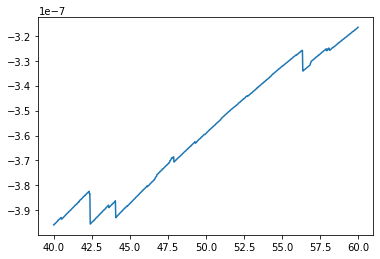

In [24]:
plt.plot(lambda_values, derivatives)

In [25]:
insample_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':100})

0.00042060832119515353